In [ ]:
import pandas as pd 
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from matplotlib.pyplot import figure
import scipy.io
plt.rcParams['figure.figsize'] == [10,10]
plt.rcParams.update({'font.size' : 18})

Error: Session cannot generate requests

# Get faces

In [2]:
path ="./CroppedYale"
filelist = []

for root, dirs, files in os.walk(path):
    for file_el in files:
        is_image = file_el.split('.')[-1] == 'pgm' 
        is_face = not ('Ambient' in file_el)
        if is_image and is_face: filelist.append(os.path.join(root, file_el))

In [3]:
X = []
X2 = []

for name in filelist:
    b=plt.imread(os.path.join(name))
    if b.shape == (192, 168): 
    # b= cv2.cvtColor(b,cv2.COLOR_GRAY2RGB) 
        X.append(b)
    else:
        X2.append(b)

There is 2432 images. Not 2414.
In place of damaged images I added some (duplicated) to have 64 images for all persons, so I can create 4d array - 38x64xHxW

In [4]:
len(X)

2432

In [5]:
len(X)/64

38.0

(-0.5, 167.5, 191.5, -0.5)

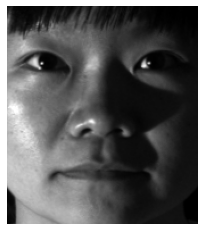

In [6]:
plt.imshow(X[255]).set_cmap('gray')
plt.axis('off')

In [7]:
face_codes = scipy.io.loadmat('face_codes.mat')

In [8]:
# columns of ufaces
# 1.face #   2.first_member  3.last_member   4.race   5.gender
ufaces = face_codes['ufaces']

In [9]:
ufaces

array([[   1,    1,   64,    1,    5],
       [   2,   65,  128,    2,    5],
       [   3,  129,  192,    1,    5],
       [   4,  193,  256,    1,    5],
       [   5,  257,  320,    2,    6],
       [   6,  321,  384,    1,    5],
       [   7,  385,  448,    1,    5],
       [   8,  449,  512,    4,    5],
       [   9,  513,  576,    4,    5],
       [  10,  577,  640,    1,    5],
       [  11,  641,  700,    4,    5],
       [  12,  701,  759,    3,    5],
       [  13,  760,  819,    2,    5],
       [  14,  820,  882,    1,    6],
       [  15,  883,  944,    1,    6],
       [  16,  945, 1007,    1,    5],
       [  17, 1008, 1070,    1,    5],
       [  18, 1071, 1134,    1,    5],
       [  19, 1135, 1198,    1,    5],
       [  20, 1199, 1262,    1,    5],
       [  21, 1263, 1326,    3,    6],
       [  22, 1327, 1390,    1,    5],
       [  23, 1391, 1454,    1,    6],
       [  24, 1455, 1518,    1,    5],
       [  25, 1519, 1582,    1,    5],
       [  26, 1583, 1646,

In [36]:
## from matlab code
# NN = np.zeros((1,2414))
# RR = np.zeros((1,2414))
# GG = np.zeros((1,2414))

# for i in range(1, ufaces.shape[0]+1):
#     NN[0, ufaces[i-1,1]-1:ufaces[i-1,2]] = i
#     RR[0, ufaces[i-1,1]-1:ufaces[i-1,2]] = ufaces[i-1,3]
#     GG[0, ufaces[i-1,1]-1:ufaces[i-1,2]] = ufaces[i-1,4]

# NN = NN.squeeze()
# RR = RR.squeeze()
# GG = GG.squeeze()

Set target and exluded face ids

In [10]:
target_person = 14
excluded_face = 27

One target image of the target person

In [11]:
target_image = ufaces[target_person, 1]

(-0.5, 167.5, 191.5, -0.5)

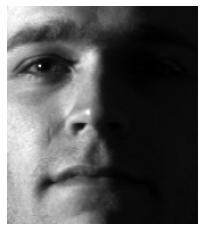

In [12]:
plt.imshow(X[target_image]).set_cmap('gray')
plt.axis('off')

Create 4d array of yalefaces

In [13]:
yalefaces = np.array(X)

In [14]:
yalefaces.shape

(2432, 192, 168)

In [15]:
38*64

2432

In [16]:
yalefaces4d = np.reshape(yalefaces, (38, 64, 192, 168))

Create pandas df from ufaces

In [17]:
ufaces_df = pd.DataFrame(data=ufaces, columns=['face_id', 'first_img', 'last_img', 'race', 'gender'])

Subtract 1 from all indexing in ufaces df to get python 0-indexing

In [18]:
ufaces_df['face_id'] = ufaces_df['face_id'].apply(lambda x: x-1)
ufaces_df['first_img'] = ufaces_df['first_img'].apply(lambda x: x-1)
ufaces_df['last_img'] = ufaces_df['last_img'].apply(lambda x: x-1)


In [19]:
ufaces_df.head()

,face_id,first_img,last_img,race,gender
0,0,0,63,1,5
1,1,64,127,2,5
2,2,128,191,1,5
3,3,192,255,1,5
4,4,256,319,2,6


Get a df of faces race=1 with 'excluded_face' (here 27) excluded from ufaces_df

In [20]:
caucasian_minus_excluded = ufaces_df.loc[(ufaces_df['race'] == 1) & (ufaces_df['face_id'] != excluded_face)]

In [21]:
caucasian_minus_excluded.shape

(26, 5)

Set all values for race != 1 and a target_person id to zero to further exclude every row that is set to 0

In [22]:
ufaces_df.loc[(ufaces_df['race'] != 1)] = 0
ufaces_df.loc[(ufaces_df['face_id'] == target_person)] = 0


In [23]:
ufaces_df.head()

,face_id,first_img,last_img,race,gender
0,0,0,63,1,5
1,0,0,0,0,0
2,2,128,191,1,5
3,3,192,255,1,5
4,0,0,0,0,0


Get a yalefaces subset with target person excluded - chooseing every row that is not set to 0 - using last_img, to include the 0-indexed person

In [24]:
yalefaces4d_target_excluded = yalefaces4d[ufaces_df['last_img'] > 0,:,:,:]


In [25]:
yalefaces4d_target_excluded.shape

(26, 64, 192, 168)

Reshape yalefaces4d_target_excluded to 3D again

In [26]:
yalefaces_target_excluded_3d = np.reshape(yalefaces4d_target_excluded, (26 * 64, 192, 168))

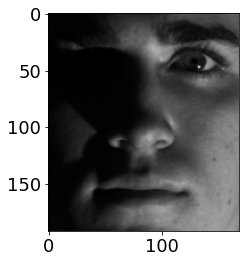

In [27]:
plt.imshow(yalefaces_target_excluded_3d[0]).set_cmap('gray')

Get ufaces df again to create subset with excluded_face excluded

In [27]:
ufaces_df = pd.DataFrame(data=ufaces, columns=['face_id', 'first_img', 'last_img', 'race', 'gender'])

In [28]:
ufaces_df.loc[(ufaces_df['race'] != 1)] = 0
ufaces_df.loc[(ufaces_df['face_id'] == excluded_face)] = 0

In [29]:
yalefaces4d_oneface_excluded = yalefaces4d[ufaces_df['last_img'] > 0,:,:,:]

In [38]:
yalefaces4d_oneface_excluded.shape

(26, 64, 192, 168)

reconstruct_face_from_library fun:

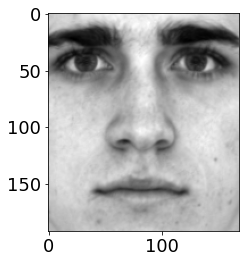

In [35]:
# yalefaces4d_target_excluded[0,:,:,:].shape
plt.imshow(np.sum(yalefaces4d_target_excluded[0,:,:,:], axis=0)).set_cmap('gray')

In [32]:
images = []
for im in yalefaces4d_target_excluded:
    summed_face = np.sum(im, axis=0)
    images.append(np.uint8((np.double(summed_face) / summed_face.max()) * 255))

In [33]:
transformed_target_excl = np.stack(images)

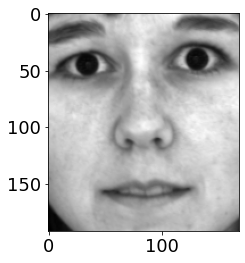

In [36]:
plt.imshow(transformed_target_excl[1]).set_cmap('gray')

In [37]:
transformed_target_excl.shape

(38, 192, 168)

In [99]:
height, width = transformed_target_excl[1].shape

1/14/2021 reconstruct with 3d 

In [28]:
height, width = yalefaces_target_excluded_3d[1].shape

In [29]:
[n, h, w] = yalefaces_target_excluded_3d.shape

In [30]:
d = h * w

In [31]:
yalefaces_target_excluded_3d.shape

(1664, 192, 168)

In [32]:
x = np.reshape(yalefaces_target_excluded_3d, (n, d))


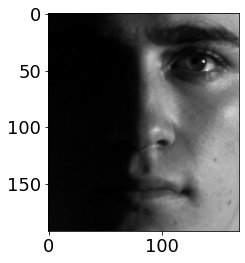

In [33]:
plt.imshow(np.reshape(x[3], (height,width))).set_cmap('gray')

In [39]:
x = x.T

In [40]:
mean_matrix = x.mean(axis=1)


In [41]:
mean_matrix.shape

(32256,)

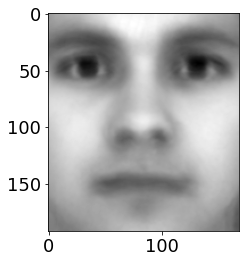

In [42]:
plt.imshow(np.reshape(mean_matrix, (height,width))).set_cmap('gray')


In [43]:
tiled_mean = np.tile(mean_matrix, (x.shape[1], 1))

In [44]:
tiled_mean.shape

(1664, 32256)

In [51]:
x.shape

(32256, 1664)

In [52]:
tiled_mean = tiled_mean.T

In [ ]:
Xtrain = x - tiled_mean

Error: Session cannot generate requests

In [54]:
Xtrain.shape

(32256, 1664)

In [55]:
s = np.cov(Xtrain)

In [ ]:
s.shape

Error: Session cannot generate requests

In [52]:
eigval, eigvec = np.linalg.eig(s)

In [45]:
eigvec.shape

(1664, 1664)

In [46]:
eigval.shape

(1664,)

In [47]:
eigval_diag = np.diag(eigval)

In [48]:
eigval_diag.shape

(1664, 1664)

In [54]:
eigval.sort()

In [56]:
#there are 1664 eigenvalues
eigval.shape

(1664,)

Evaluate the number of principal components needed to represent 95% Total variance.

In [58]:
eigsum = sum(eigval)

In [59]:
eigsum

(4264762.120730624+0j)

In [63]:
csum = 0

In [ ]:
for i in range(0, 1664):
    csum = csum + eigval(i)

In [64]:
csum = csum + eigval[0]

In [67]:
tv = csum / eigsum

In [69]:
if tv > 0.95:
    print(tv)


# Plot faces

In [5]:
m = X[2].shape[1]
n = X[2].shape[0]

In [6]:
allPersons = np.zeros((n*6, m*6))


In [7]:
stacked = np.stack(X)

In [8]:
allPersons.shape

(1152, 1008)

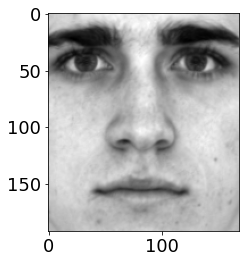

In [9]:
plt.imshow(np.sum(stacked[0:64], axis=0)).set_cmap('gray')

In [10]:
count = 0
for j in range(6):
    for k in range(6):
        allPersons[j*n : (j+1)*n, k*m : (k+1)*m] = np.sum(stacked[count : count+64], axis=0)
        count+=64

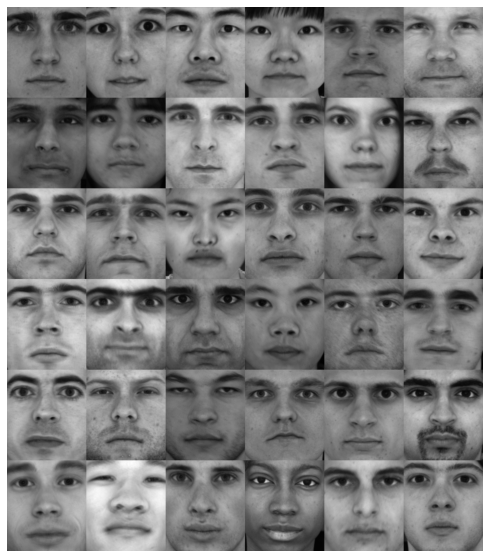

In [12]:
img = plt.imshow(allPersons).set_cmap('gray')
plt.axis('off')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [13]:
faces = np.zeros((len(X[3].flatten()), len(X))).T

In [14]:
faces.shape

(2424, 32256)

In [15]:
for i, el in enumerate(X):
    el = el.flatten().T
    if faces[i,:].shape == el.shape:
        faces[i,:] = el


# X[3].flatten()

In [19]:
# allPersons = allPersons.T

# Get training faces

In [16]:
training_faces = faces[:2304, :]

In [17]:
training_faces.shape

(2304, 32256)

(-0.5, 167.5, 191.5, -0.5)

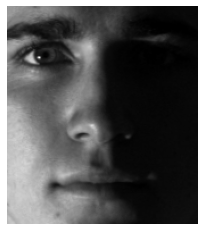

In [19]:
img_avg = plt.imshow(np.reshape(training_faces[15], (n,m)))
plt.rcParams["figure.figsize"] = (4,4)
img_avg.set_cmap('gray')
plt.axis('off')


In [20]:
av_face = np.mean(training_faces, axis=0)

In [21]:
av_face.shape

(32256,)

(-0.5, 167.5, 191.5, -0.5)

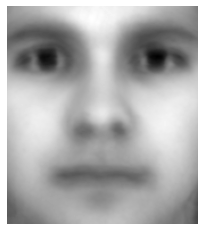

In [22]:
img_avg = plt.imshow(np.reshape(av_face, (n,m)))
img_avg.set_cmap('gray')
plt.axis('off')


In [27]:
training_faces.shape

(2304, 32256)

In [23]:
Xtrain = training_faces - np.tile(av_face, (training_faces.shape[0], 1))

In [24]:
Xtrain.T.shape

(32256, 2304)

(-0.5, 167.5, 191.5, -0.5)

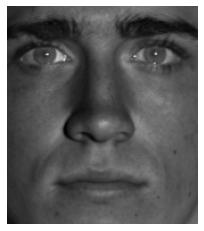

In [25]:
plt.imshow(np.reshape(Xtrain[30], (n,m)))
plt.set_cmap('gray')
plt.axis('off')

# SVD/PCA

In [26]:
U, S, VT = np.linalg.svd(Xtrain.T, full_matrices=0)

In [32]:
U.shape

(32256, 2304)

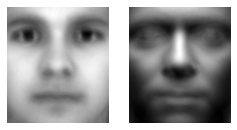

In [27]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(av_face, (n,m)))
img_avg.set_cmap('gray')
plt.axis('off')

ax2 = fig1.add_subplot(122)
img_avg1 = ax2.imshow(np.reshape(U[:,2], (n,m)))
img_avg1.set_cmap('gray')
plt.axis('off')

plt.show()

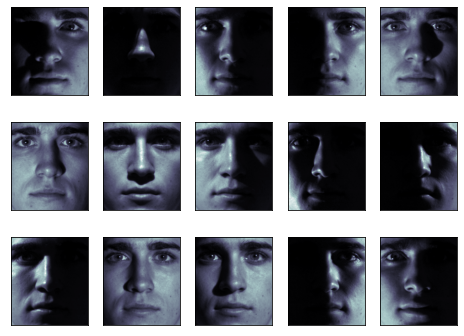

In [342]:
#plot face-grid

# fig = plt.figure(figsize=(8, 6))
# for i in range(15):
#     ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
#     ax.imshow(X[i], cmap=plt.cm.bone)

# Reconstruct test face

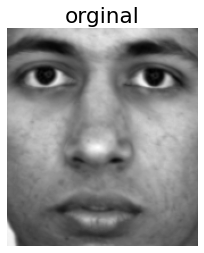

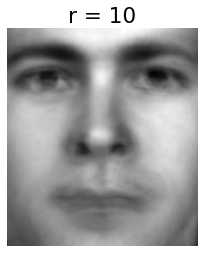

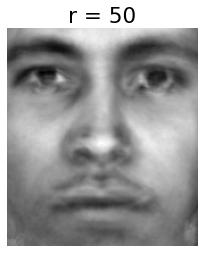

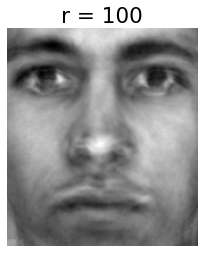

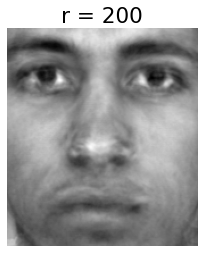

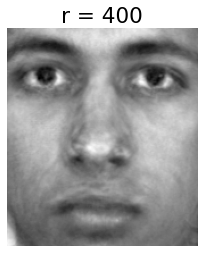

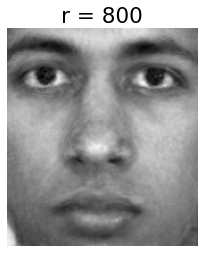

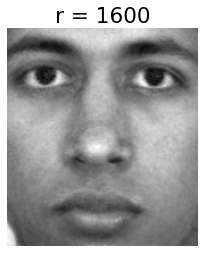

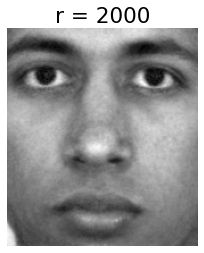

In [28]:
testface = np.sum(faces[2306:2368], axis=0)
plt.imshow(np.reshape(testface, (n,m)))
plt.set_cmap('gray')
plt.axis('off')
plt.title('orginal')
plt.show()

testFaceMS = testface.squeeze() - av_face
r_list = [10, 50, 100, 200, 400, 800, 1600, 2000]

for r in r_list:
    reconFace = av_face + U[:,:r] @ (U[:, :r].T @ testFaceMS)
    img = plt.imshow(np.reshape(reconFace, (n,m)))
    img.set_cmap('gray')
    plt.title('r = ' + str(r))
    plt.axis('off')
    plt.show()

# Explore components differentiating two faces
 

 Choose two faces

In [29]:
p1 = 5
p2 = 8

face1 = training_faces[64*(p1-1):64*p1]
face2 = training_faces[64*(p2-1):64*p2]

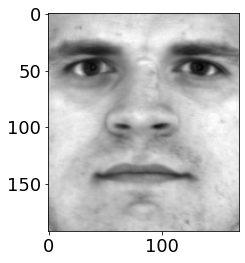

In [30]:
plt.imshow(np.reshape(np.sum(face1, axis=0), (n,m)))


Subtract the avg face

In [31]:
face1 = face1 - np.tile(av_face, (face1.shape[0], 1))
face2 = face2 - np.tile(av_face, (face2.shape[0], 1))


Project on two principle components and plot them against each other

In [32]:
PCAmodes = [5,6]
PCAcoords1 = U[:, PCAmodes-np.ones_like(PCAmodes)].T @ face1.T
PCAcoords2 = U[:, PCAmodes-np.ones_like(PCAmodes)].T @ face2.T


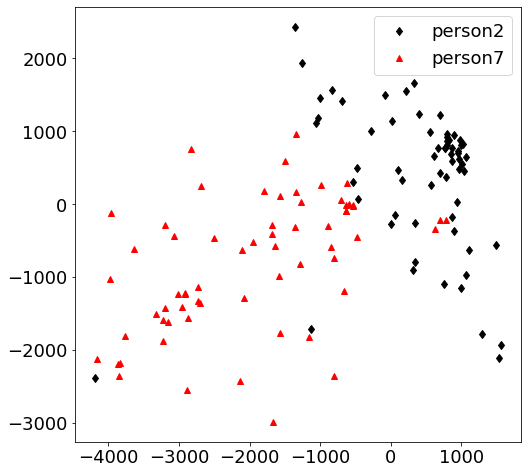

In [33]:
plt.figure(figsize=(8,8))
plt.plot(PCAcoords1[0, :], PCAcoords1[1, :], 'd', color='k', label='person2' )
plt.plot(PCAcoords2[0, :], PCAcoords2[1, :], '^', color='r', label='person7' )

plt.legend()
plt.show()


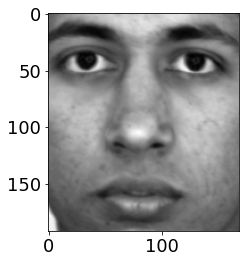

In [34]:
testface = np.sum(faces[2306:2368], axis=0)
plt.imshow(np.reshape(testface, (n,m)))